In [1]:
import torch
import pickle
import numpy as np
from evaluation import *
from functions import *
from Models.UNetEx import *
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading dataset
x = pickle.load(open("./Xs.pkl", "rb"))
y = pickle.load(open("./Ys.pkl", "rb"))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

In [4]:
# Shifting dimensions
x, y = x.permute(0, 3, 1, 2), y.permute(0, 3, 1, 2)
# Removing channel 1 in input channels
x = torch.cat((x[:, 0:1, :, :], x[:, 2:, :, :]), dim=1)
# Adding binary channel to describe the shape of object
bin_channel = torch.isnan(x[:, 2:, :, :]).type(torch.float)
x = torch.cat([x, bin_channel], dim=1)
print(torch.sum(bin_channel))

tensor(467592.)


In [5]:
# Removing NaN values
x[torch.isnan(x)] = 0
y[torch.isnan(y)] = 0

In [6]:
# Computing Root Mean Square of features to equally prioritize each feature in loss function
features_mse = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1).view(-1, y.shape[1]) ** 2, dim=0)).view(1, -1, 1, 1).to(device)
print(features_mse)

tensor([[[[0.1156]],

         [[0.0173]],

         [[0.0135]]]], device='cuda:0')


In [7]:
print(x.shape)
print(y.shape)

torch.Size([961, 4, 172, 79])
torch.Size([961, 3, 172, 79])


In [8]:
# Shuffling the dataset
x, y = shuffle_tensors(x, y)

In [9]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)
train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)

In [10]:
# Creating model
model = UNetEx(4, 3, filters=[8,16,32,32], kernel_size=5,
                    batch_norm=False, weight_norm=True)
model

UNetEx(
  (encoder): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
    )
    (3): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padd

In [11]:
# Initializing weights
# initialize(model)

In [12]:
# Initializing optimizer
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [13]:
# Defining loss function
def loss_func(model, batch):
    x, y = batch
    output = model(x)
    loss = ((output - y) ** 2) / features_mse
    return torch.sum(loss), output

In [14]:
# Selecting sample from test dataset for visualization
sample_x, sample_y = test_data[0][0:1].to(device), test_data[1][0:1].to(device)

In [15]:
# Computing output and error for test sample
def compute_error(model, sample_x, sample_y):
    with torch.no_grad():
        out_y = model(sample_x)
        error = torch.abs(sample_y - out_y)
        return out_y, error

In [16]:
# Visualize sample
def visualize(sample_y, out_y, error):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
    plt.subplot(3, 3, 1)
    plt.title('CFD', fontsize=18) 
    plt.imshow(np.transpose(sample_y[0,0,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Ux', fontsize=18)
    plt.subplot(3, 3, 2)
    plt.title('CNN', fontsize=18) 
    plt.imshow(np.transpose(out_y[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 3)
    plt.title('Error', fontsize=18)
    plt.imshow(np.transpose(error[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 4)
    plt.imshow(np.transpose(sample_y[0,1,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Uy', fontsize=18)
    plt.subplot(3, 3, 5)
    plt.imshow(np.transpose(out_y[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 6)
    plt.imshow(np.transpose(error[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 7)
    plt.imshow(np.transpose(sample_y[0,2,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('p', fontsize=18)
    plt.subplot(3, 3, 8)
    plt.imshow(np.transpose(out_y[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 9)
    plt.imshow(np.transpose(error[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.tight_layout()
    plt.show()

In [17]:
# Visualize after N epochs
def after_epoch(scope):
    epoch = scope["epoch"]
    best_model = scope["best_model"]
    if epoch % 10 == 0:
        out_y, error = compute_error(best_model, sample_x, sample_y)
        visualize(sample_y.cpu().numpy(), out_y.cpu().numpy(), error.cpu().numpy())

Epoch #1
	Train Loss = 3966760.390625
	Train Total MSE = 248.83712405250185
	Train Ux MSE = 177.9779990059989
	Train Uy MSE = 54.645604269845144
	Train p MSE = 16.213518483298166
	Validation Loss = 894292.5087890625
	Validation Total MSE = 172.3339311540333
	Validation Ux MSE = 140.57079507900357
	Validation Uy MSE = 29.170279743762165
	Validation p MSE = 2.592858918397897
Model saved!
Epoch #2
	Train Loss = 1489924.63671875
	Train Total MSE = 120.72616104852585
	Train Ux MSE = 98.2092643011184
	Train Uy MSE = 18.503905205499557
	Train p MSE = 4.012992972419376
	Validation Loss = 407259.91149902344
	Validation Total MSE = 75.19909757726333
	Validation Ux MSE = 60.69846895739281
	Validation Uy MSE = 11.709947058073789
	Validation p MSE = 2.7906811427080096
Model saved!
Epoch #3
	Train Loss = 807798.291015625
	Train Total MSE = 61.714496430896574
	Train Ux MSE = 49.26306915283203
	Train Uy MSE = 9.043124880109515
	Train p MSE = 3.408302352541969
	Validation Loss = 263408.54736328125
	Val

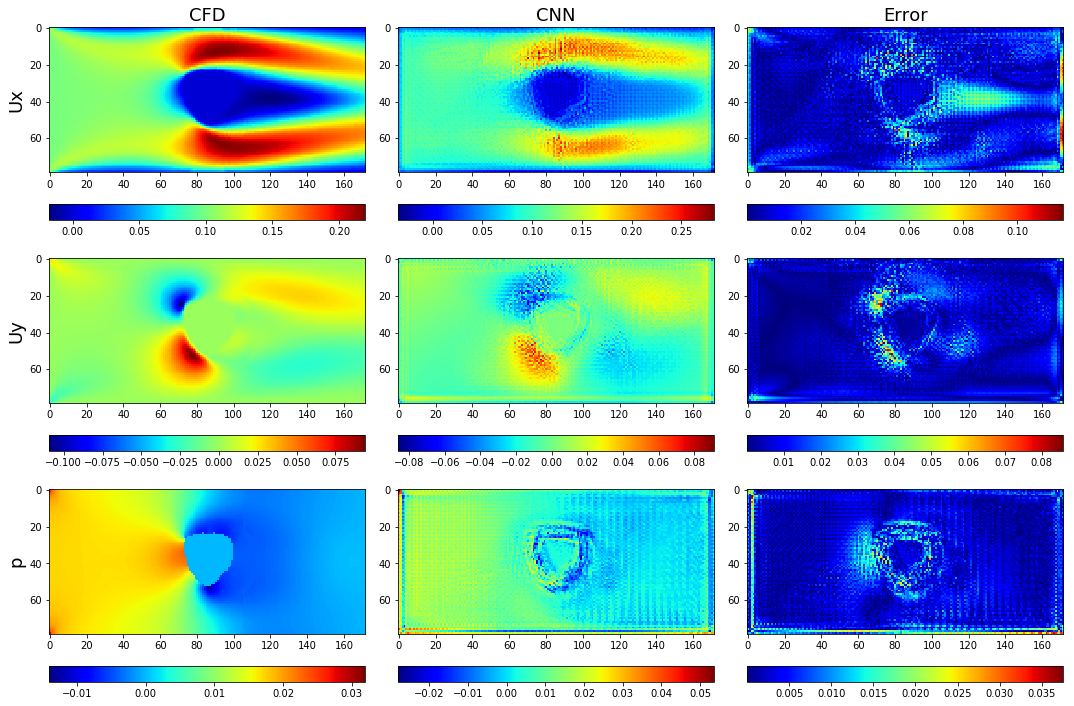

Epoch #11
	Train Loss = 179686.32421875
	Train Total MSE = 9.524876685369582
	Train Ux MSE = 6.36382345926194
	Train Uy MSE = 1.3682496547698975
	Train p MSE = 1.7928037104152499
	Validation Loss = 48381.60831451416
	Validation Total MSE = 7.627894302552959
	Validation Ux MSE = 5.778954571918633
	Validation Uy MSE = 1.2100328009021324
	Validation p MSE = 0.6389068396033712
Model saved!
Epoch #12
	Train Loss = 166218.60546875
	Train Total MSE = 8.58964577175322
	Train Ux MSE = 5.651970477331252
	Train Uy MSE = 1.203766175678798
	Train p MSE = 1.7339091755094982
	Validation Loss = 42920.12190246582
	Validation Total MSE = 6.794922251189869
	Validation Ux MSE = 5.167490645675923
	Validation Uy MSE = 1.0373141270607813
	Validation p MSE = 0.5901175585791314
Model saved!
Epoch #13
	Train Loss = 156127.314453125
	Train Total MSE = 7.91039684840611
	Train Ux MSE = 5.142395450955346
	Train Uy MSE = 1.0826433130672999
	Train p MSE = 1.6853583298978352
	Validation Loss = 39456.30599975586
	Valid

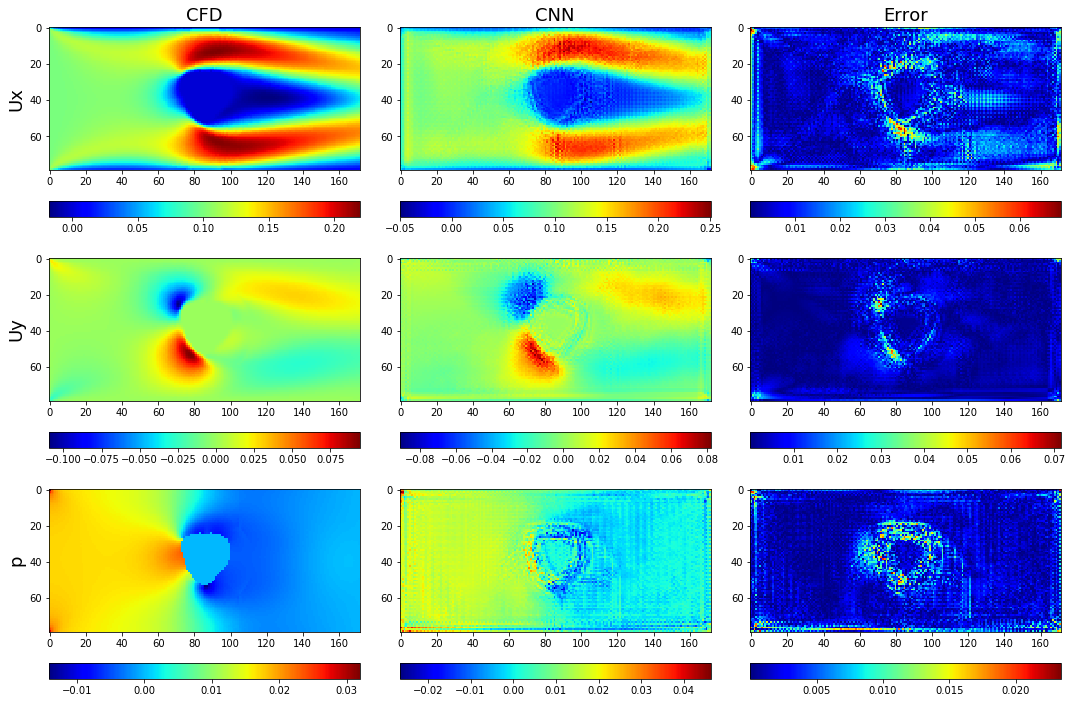

Epoch #21
	Train Loss = 122600.64770507812
	Train Total MSE = 5.464710371834891
	Train Ux MSE = 3.230391127722604
	Train Uy MSE = 0.7006875986144656
	Train p MSE = 1.533631546156747
	Validation Loss = 26267.574668884277
	Validation Total MSE = 3.9696309525248914
	Validation Ux MSE = 2.959606932933768
	Validation Uy MSE = 0.5917294887522925
	Validation p MSE = 0.4182946200911149
Model saved!
Epoch #22
	Train Loss = 121805.36364746094
	Train Total MSE = 5.3718999453953336
	Train Ux MSE = 3.147548414411999
	Train Uy MSE = 0.684122751156489
	Train p MSE = 1.5402287195126216
	Validation Loss = 25490.807106018066
	Validation Total MSE = 3.8192171068752514
	Validation Ux MSE = 2.8346765767331767
	Validation Uy MSE = 0.5743744273292977
	Validation p MSE = 0.4101660068059875
Model saved!
Epoch #23
	Train Loss = 119644.14099121094
	Train Total MSE = 5.257389204842704
	Train Ux MSE = 3.0730778603326705
	Train Uy MSE = 0.6596703004269373
	Train p MSE = 1.5246410447926748
	Validation Loss = 24827.9

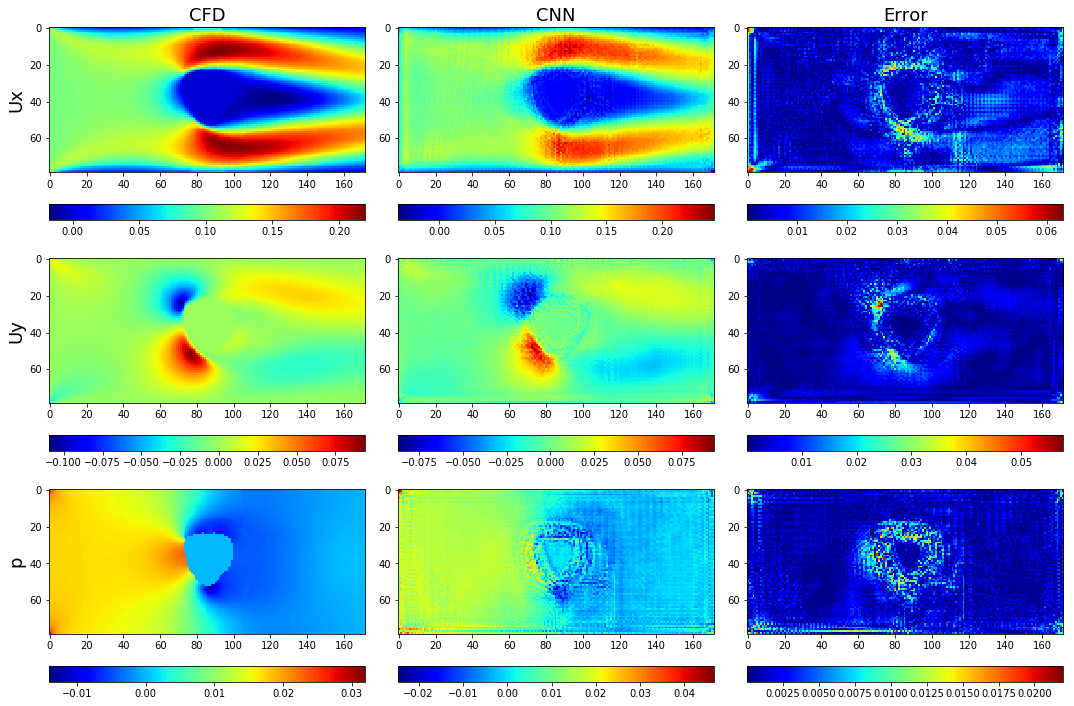

Epoch #31
	Train Loss = 111039.80163574219
	Train Total MSE = 4.646525882539295
	Train Ux MSE = 2.601772603534517
	Train Uy MSE = 0.5601316222122737
	Train p MSE = 1.4846217078822
	Validation Loss = 21950.71183013916
	Validation Total MSE = 3.1723234913340903
	Validation Ux MSE = 2.3102376725021943
	Validation Uy MSE = 0.4903943517010105
	Validation p MSE = 0.371691414641674
Epoch #32
	Train Loss = 111186.55822753906
	Train Total MSE = 4.662314812342326
	Train Ux MSE = 2.615404662631807
	Train Uy MSE = 0.5637496638865698
	Train p MSE = 1.483160492210161
	Validation Loss = 21816.81150817871
	Validation Total MSE = 3.1705126477772803
	Validation Ux MSE = 2.3168718295113853
	Validation Uy MSE = 0.4839199265806733
	Validation p MSE = 0.3697210041915669
Epoch #33
	Train Loss = 110105.37524414062
	Train Total MSE = 4.568997564769926
	Train Ux MSE = 2.5378047284625826
	Train Uy MSE = 0.5498082027548835
	Train p MSE = 1.4813846938666844
	Validation Loss = 21128.41427230835
	Validation Total MS

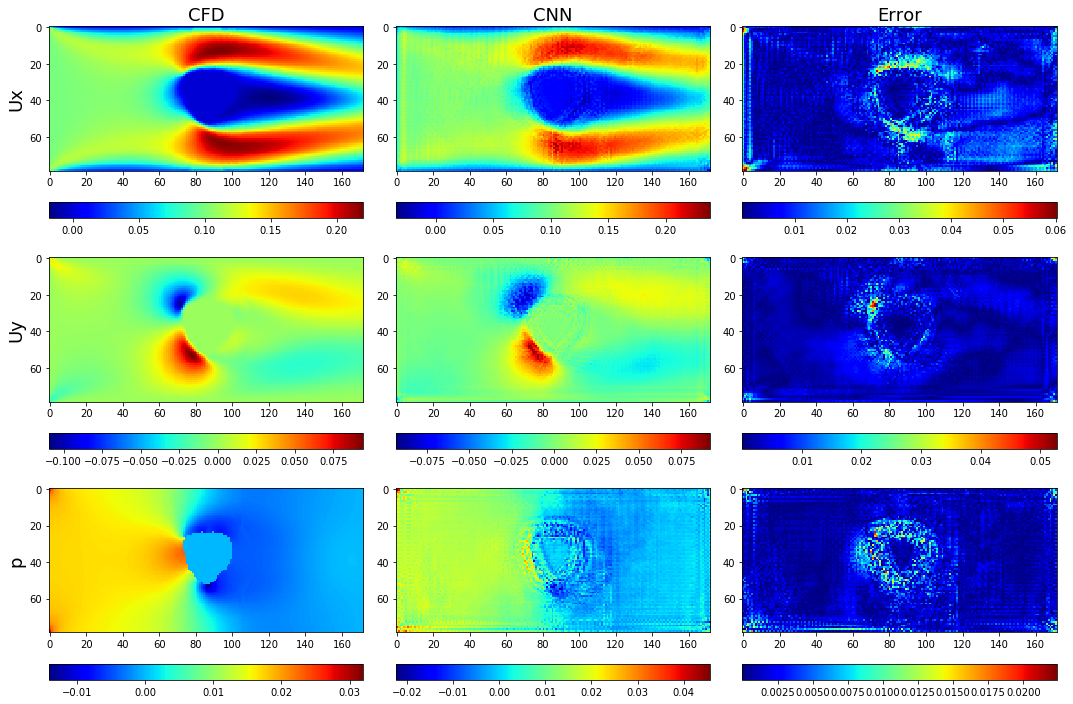

Epoch #41
	Train Loss = 104689.70788574219
	Train Total MSE = 4.205651033492315
	Train Ux MSE = 2.265086838177272
	Train Uy MSE = 0.4871312450794947
	Train p MSE = 1.4534329136922246
	Validation Loss = 18976.612422943115
	Validation Total MSE = 2.7337702112626863
	Validation Ux MSE = 1.994470085445985
	Validation Uy MSE = 0.39562218298549057
	Validation p MSE = 0.3436779544324611
Model saved!
Epoch #42
	Train Loss = 104389.09436035156
	Train Total MSE = 4.164459466934204
	Train Ux MSE = 2.2266310566947576
	Train Uy MSE = 0.4817740661757333
	Train p MSE = 1.456054303262915
	Validation Loss = 19138.659393310547
	Validation Total MSE = 2.841486402861387
	Validation Ux MSE = 2.1087176940020393
	Validation Uy MSE = 0.3921014007606308
	Validation p MSE = 0.3406672166293055
Epoch #43
	Train Loss = 104791.75
	Train Total MSE = 4.20443412235805
	Train Ux MSE = 2.2609294596172513
	Train Uy MSE = 0.4889922212986719
	Train p MSE = 1.454512269723983
	Validation Loss = 18881.863204956055
	Validation

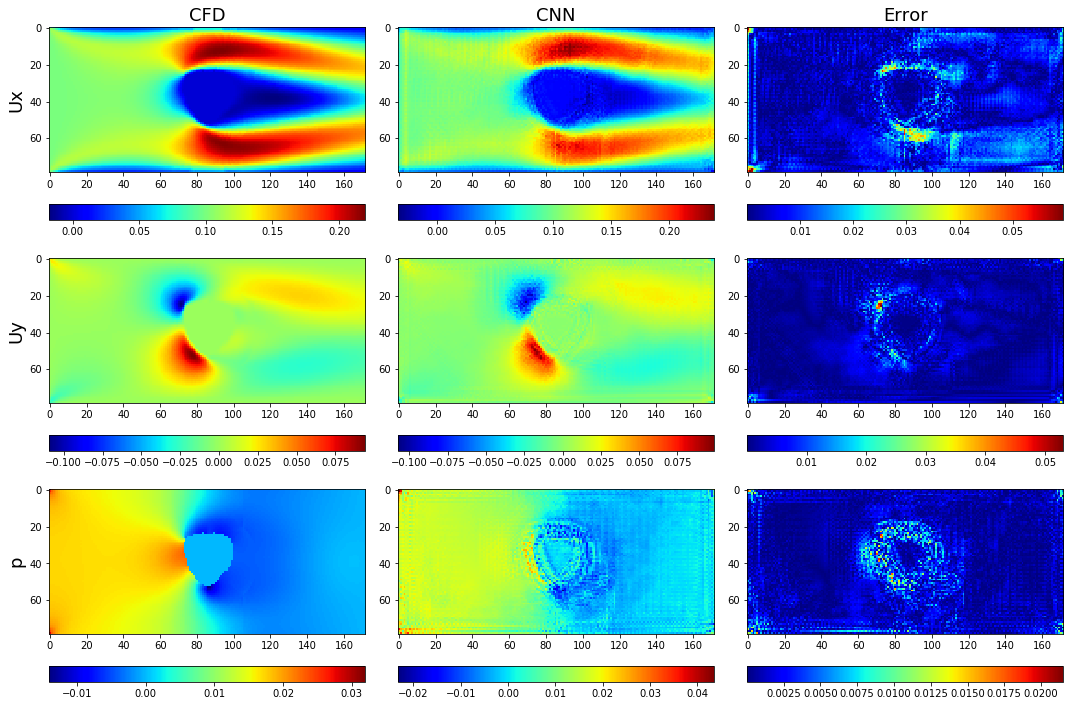

Epoch #51
	Train Loss = 102148.27575683594
	Train Total MSE = 3.989242684273493
	Train Ux MSE = 2.0857359227680026
	Train Uy MSE = 0.45545336462202524
	Train p MSE = 1.4480534291693143
	Validation Loss = 17628.97472000122
	Validation Total MSE = 2.491787387631756
	Validation Ux MSE = 1.799268435235667
	Validation Uy MSE = 0.36523207939619834
	Validation p MSE = 0.32728689377901876
Epoch #52
	Train Loss = 101196.54248046875
	Train Total MSE = 3.9268375975745067
	Train Ux MSE = 2.0381083204632713
	Train Uy MSE = 0.4497606825260889
	Train p MSE = 1.438968565492403
	Validation Loss = 17747.82021331787
	Validation Total MSE = 2.4510745645394376
	Validation Ux MSE = 1.7429381210911232
	Validation Uy MSE = 0.38110971677674554
	Validation p MSE = 0.32702674577496044
Epoch #53
	Train Loss = 101079.71954345703
	Train Total MSE = 3.942000843229748
	Train Ux MSE = 2.0593619289852323
	Train Uy MSE = 0.444011104958398
	Train p MSE = 1.4386278972739266
	Validation Loss = 17182.85617828369
	Validation

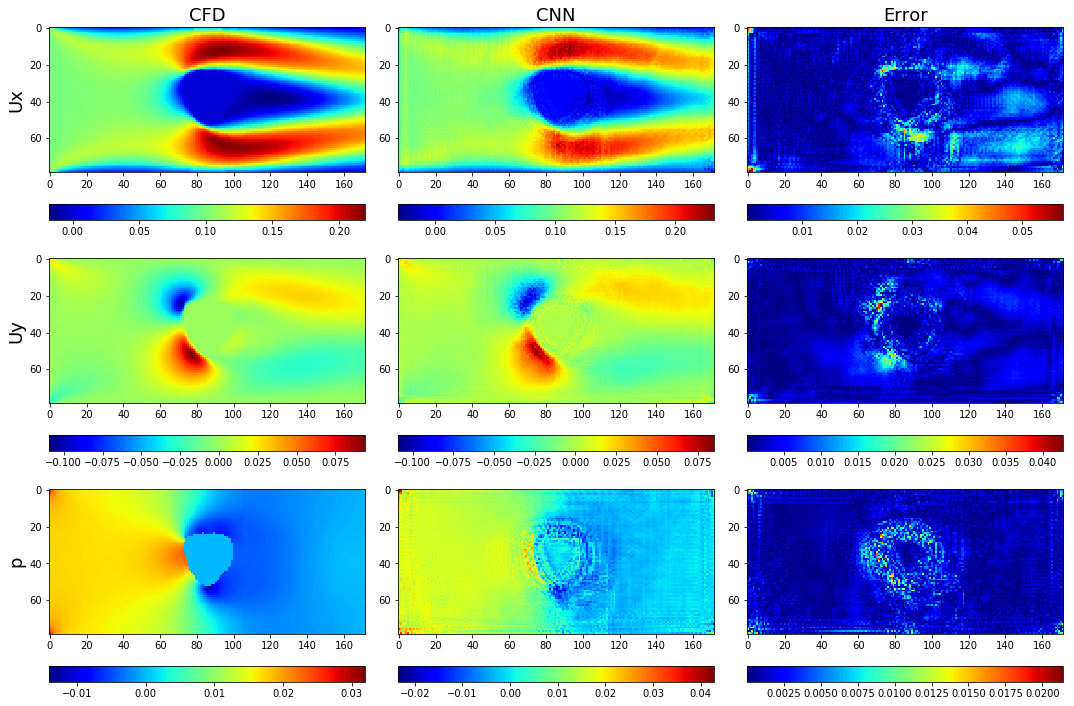

Epoch #61
	Train Loss = 98943.47143554688
	Train Total MSE = 3.786752218291873
	Train Ux MSE = 1.9392541079294114
	Train Uy MSE = 0.4154684486843291
	Train p MSE = 1.4320296843846638
	Validation Loss = 16652.53883743286
	Validation Total MSE = 2.348245386433849
	Validation Ux MSE = 1.6961521745553065
	Validation Uy MSE = 0.3338962601542885
	Validation p MSE = 0.31819694612987315
Model saved!
Epoch #62
	Train Loss = 98965.13940429688
	Train Total MSE = 3.7810401065008983
	Train Ux MSE = 1.9328759057181222
	Train Uy MSE = 0.413177558353969
	Train p MSE = 1.434986676488604
	Validation Loss = 16929.39831161499
	Validation Total MSE = 2.3400625671069926
	Validation Ux MSE = 1.6735793121133296
	Validation Uy MSE = 0.3288474411906668
	Validation p MSE = 0.3376357436798848
Epoch #63
	Train Loss = 98451.5151977539
	Train Total MSE = 3.736689578919184
	Train Ux MSE = 1.896479294413612
	Train Uy MSE = 0.40460836319696336
	Train p MSE = 1.4356018180648487
	Validation Loss = 16576.430938720703
	Val

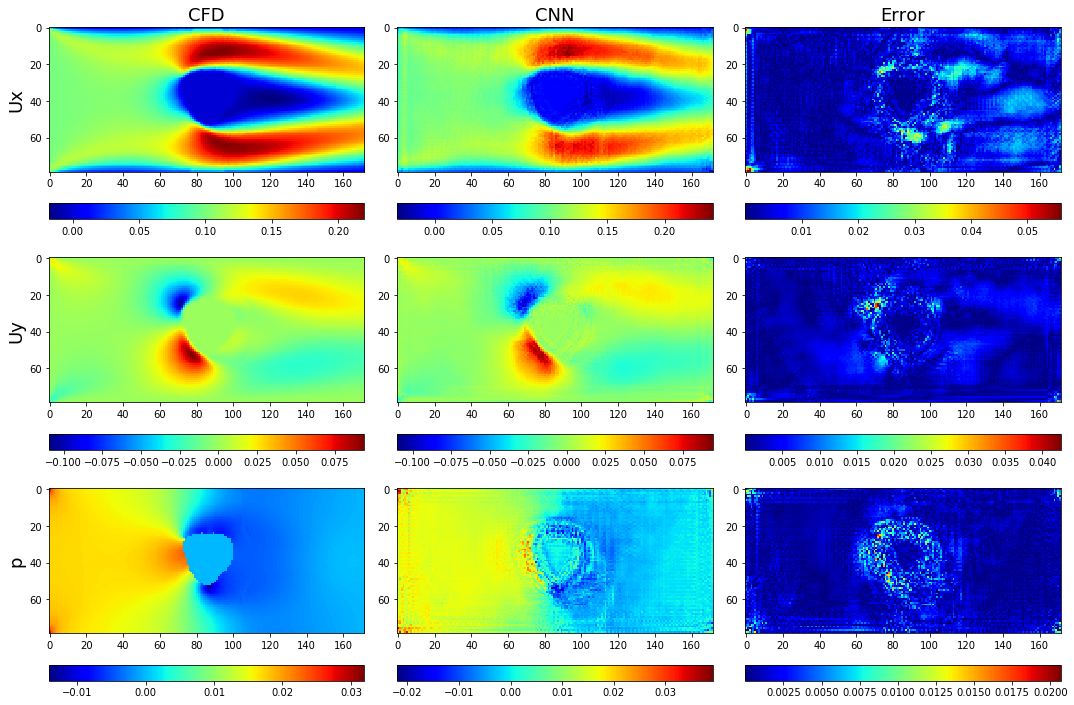

Epoch #71
	Train Loss = 97328.15014648438
	Train Total MSE = 3.649449041911534
	Train Ux MSE = 1.8261597497122628
	Train Uy MSE = 0.3928584172612145
	Train p MSE = 1.430430775596982
	Validation Loss = 16166.662746429443
	Validation Total MSE = 2.2097910745746123
	Validation Ux MSE = 1.5703262985783877
	Validation Uy MSE = 0.31299327045782216
	Validation p MSE = 0.326471426134291
Epoch #72
	Train Loss = 96903.1342163086
	Train Total MSE = 3.6499548866635276
	Train Ux MSE = 1.8378092561449324
	Train Uy MSE = 0.3871036072572072
	Train p MSE = 1.4250420253901255
	Validation Loss = 15793.089757919312
	Validation Total MSE = 2.1532833858757283
	Validation Ux MSE = 1.5269965789309834
	Validation Uy MSE = 0.30926337869109577
	Validation p MSE = 0.31702341917889343
Model saved!
Epoch #73
	Train Loss = 96599.26458740234
	Train Total MSE = 3.6074492306936357
	Train Ux MSE = 1.7965158167339506
	Train Uy MSE = 0.3874038074697767
	Train p MSE = 1.4235295919435365
	Validation Loss = 15528.34903907775

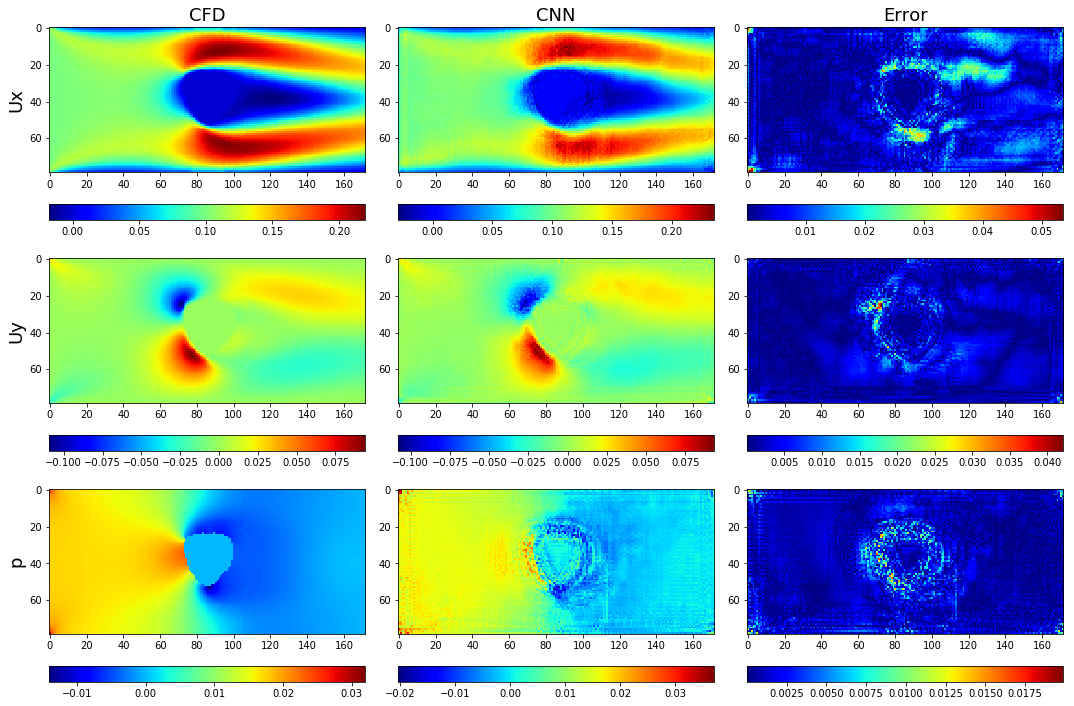

Epoch #81
	Train Loss = 95287.18133544922
	Train Total MSE = 3.5083192643665133
	Train Ux MSE = 1.7176539585703896
	Train Uy MSE = 0.3731232895737603
	Train p MSE = 1.4175419385234516
	Validation Loss = 15308.05512714386
	Validation Total MSE = 2.078902318609627
	Validation Ux MSE = 1.470655792724715
	Validation Uy MSE = 0.30019454044454236
	Validation p MSE = 0.3080520027906837
Epoch #82
	Train Loss = 95957.86950683594
	Train Total MSE = 3.5584748415719893
	Train Ux MSE = 1.7556276945840745
	Train Uy MSE = 0.3873892830950873
	Train p MSE = 1.4154579281097366
	Validation Loss = 15468.72214126587
	Validation Total MSE = 2.058954699641693
	Validation Ux MSE = 1.4340148380470936
	Validation Uy MSE = 0.32245425297314734
	Validation p MSE = 0.3024856350980828
Epoch #83
	Train Loss = 96258.03350830078
	Train Total MSE = 3.5615314018158686
	Train Ux MSE = 1.7528516678583055
	Train Uy MSE = 0.3851449439922969
	Train p MSE = 1.423534750583626
	Validation Loss = 15668.144752502441
	Validation To

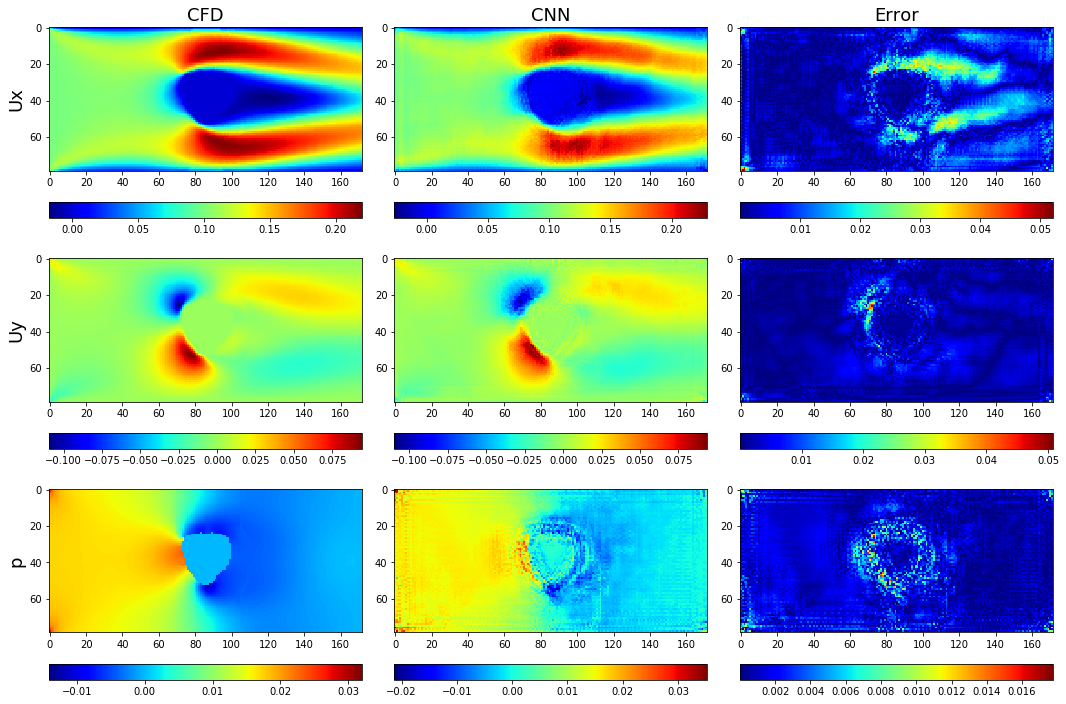

Epoch #91
	Train Loss = 94020.1298828125
	Train Total MSE = 3.412268496695019
	Train Ux MSE = 1.6408283682096572
	Train Uy MSE = 0.3605434575251171
	Train p MSE = 1.410896676282088
	Validation Loss = 14791.491619110107
	Validation Total MSE = 1.9849765193503621
	Validation Ux MSE = 1.3975639145267051
	Validation Uy MSE = 0.2764052286950362
	Validation p MSE = 0.3110074166556543
Epoch #92
	Train Loss = 93924.095703125
	Train Total MSE = 3.416490452630179
	Train Ux MSE = 1.6479196065948123
	Train Uy MSE = 0.3599957880519685
	Train p MSE = 1.4085751527122088
	Validation Loss = 14651.809343338013
	Validation Total MSE = 1.9808584183557636
	Validation Ux MSE = 1.3992193042200742
	Validation Uy MSE = 0.28054485601537366
	Validation p MSE = 0.30109423440220445
Epoch #93
	Train Loss = 94340.93127441406
	Train Total MSE = 3.4391817933037165
	Train Ux MSE = 1.6655728220939636
	Train Uy MSE = 0.3543655751716523
	Train p MSE = 1.4192433651714098
	Validation Loss = 14483.143014907837
	Validation To

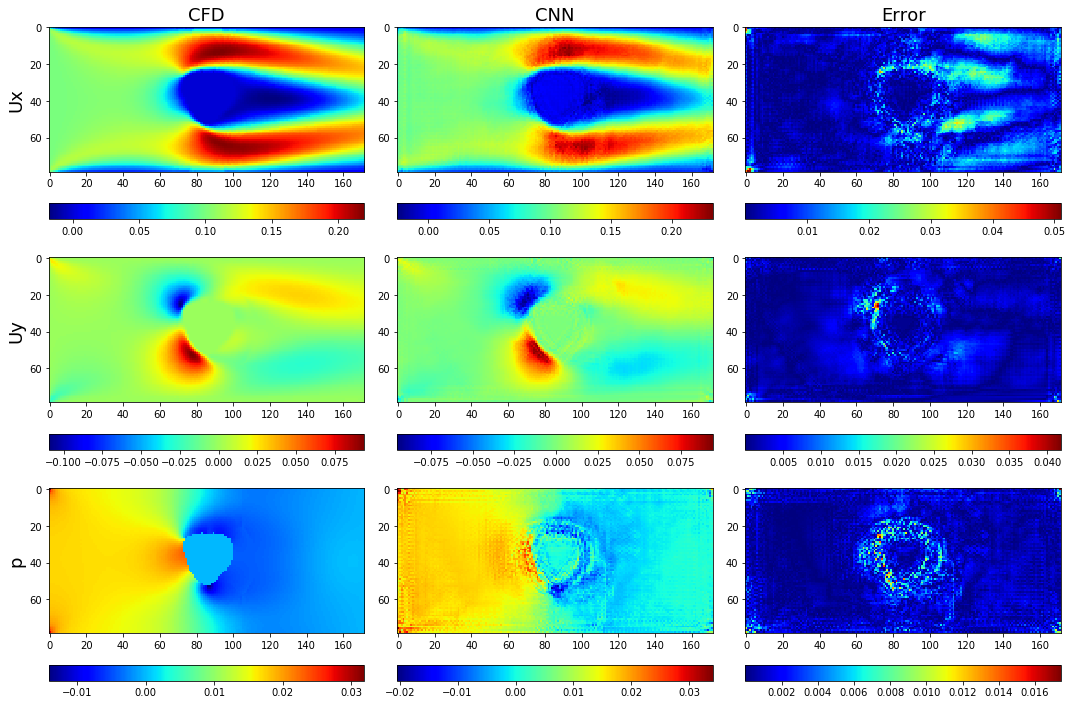

Epoch #101
	Train Loss = 92658.59442138672
	Train Total MSE = 3.3083718844822476
	Train Ux MSE = 1.5574424181665694
	Train Uy MSE = 0.34725619284879594
	Train p MSE = 1.403673248276824
	Validation Loss = 14451.312070846558
	Validation Total MSE = 1.913143821034877
	Validation Ux MSE = 1.3377374047639048
	Validation Uy MSE = 0.2623281845739144
	Validation p MSE = 0.3130782515223051
Epoch #102
	Train Loss = 93765.49475097656
	Train Total MSE = 3.351773352850051
	Train Ux MSE = 1.5812424563226246
	Train Uy MSE = 0.34820992889858426
	Train p MSE = 1.422320998850323
	Validation Loss = 15031.20393371582
	Validation Total MSE = 2.0178721392443437
	Validation Ux MSE = 1.4194354606747215
	Validation Uy MSE = 0.2872403320762938
	Validation p MSE = 0.31119634716362277
Epoch #103
	Train Loss = 94507.6939086914
	Train Total MSE = 3.3872139851252236
	Train Ux MSE = 1.6011827105567569
	Train Uy MSE = 0.36152676954155877
	Train p MSE = 1.4245045039625395
	Validation Loss = 14141.631860733032
	Validati

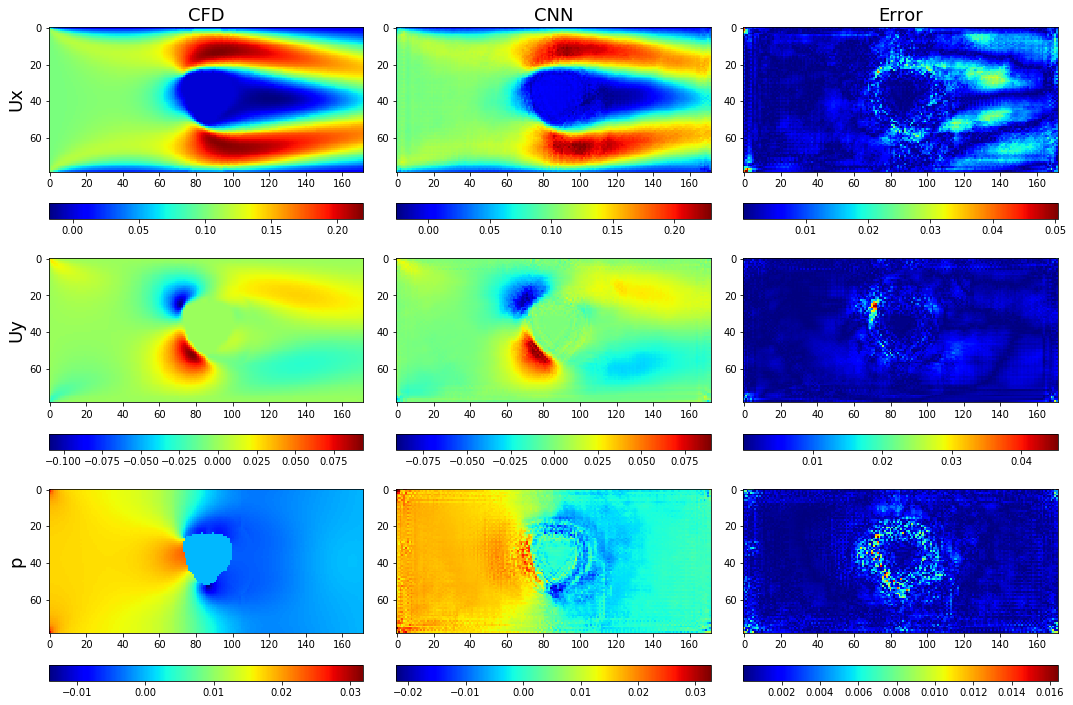

Epoch #111
	Train Loss = 91885.31909179688
	Train Total MSE = 3.2755674804959978
	Train Ux MSE = 1.5400198385829018
	Train Uy MSE = 0.3385851397400811
	Train p MSE = 1.3969624780473255
	Validation Loss = 14195.472885131836
	Validation Total MSE = 1.9289177441679484
	Validation Ux MSE = 1.3668291810062105
	Validation Uy MSE = 0.27120729971509494
	Validation p MSE = 0.29088125937331505
Epoch #112
	Train Loss = 91944.11437988281
	Train Total MSE = 3.2416210174560547
	Train Ux MSE = 1.4995802016485305
	Train Uy MSE = 0.34133414924144745
	Train p MSE = 1.400706709140823
	Validation Loss = 14080.454109191895
	Validation Total MSE = 1.8329396293237548
	Validation Ux MSE = 1.2696663267059722
	Validation Uy MSE = 0.2497884816519117
	Validation p MSE = 0.3134848275399126
Epoch #113
	Train Loss = 91366.19445800781
	Train Total MSE = 3.2036102556046986
	Train Ux MSE = 1.4725914682660783
	Train Uy MSE = 0.32967964879104067
	Train p MSE = 1.4013392229874928
	Validation Loss = 13758.345569610596
	Val

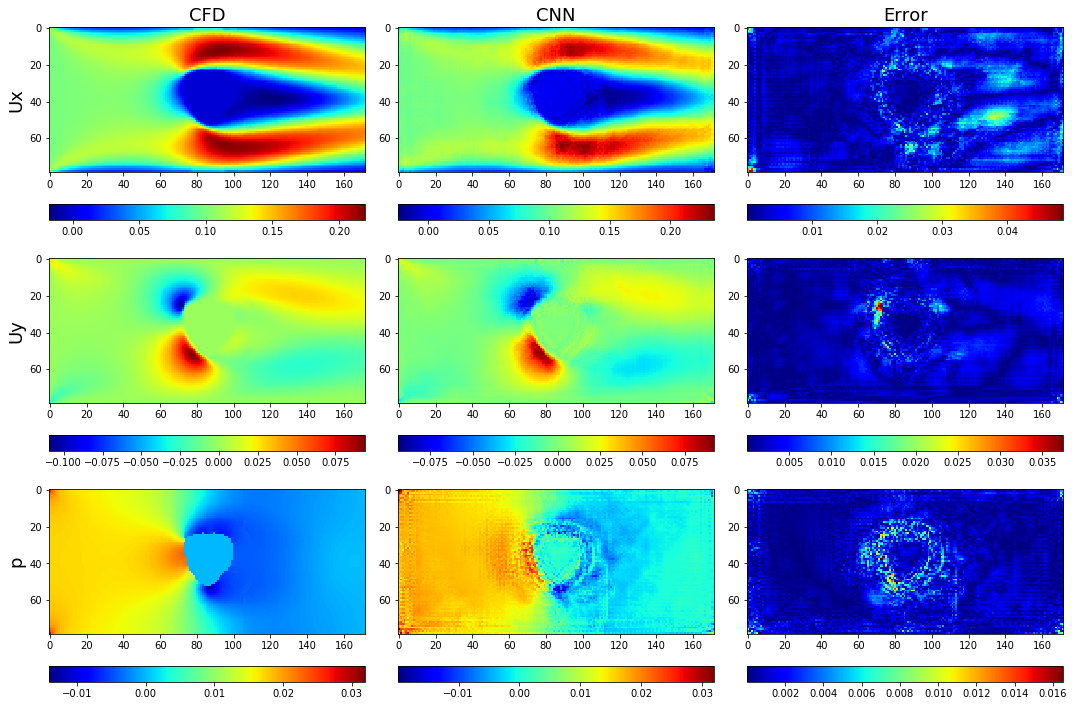

Epoch #121
	Train Loss = 91185.25799560547
	Train Total MSE = 3.1553804533822194
	Train Ux MSE = 1.4225145124253773
	Train Uy MSE = 0.3280766592139289
	Train p MSE = 1.4047892491022747
	Validation Loss = 13423.96673297882
	Validation Total MSE = 1.7143548260923076
	Validation Ux MSE = 1.1682581750991847
	Validation Uy MSE = 0.2569081031275868
	Validation p MSE = 0.2891885512943499
Epoch #122
	Train Loss = 90839.49908447266
	Train Total MSE = 3.147830054873512
	Train Ux MSE = 1.4217457742918105
	Train Uy MSE = 0.3283034783034098
	Train p MSE = 1.3977808459174066
	Validation Loss = 13057.107620239258
	Validation Total MSE = 1.6913430942383605
	Validation Ux MSE = 1.165890369242038
	Validation Uy MSE = 0.2396337365970067
	Validation p MSE = 0.2858190183047605
Model saved!
Epoch #123
	Train Loss = 90975.0484008789
	Train Total MSE = 3.163114036832537
	Train Ux MSE = 1.435636159919557
	Train Uy MSE = 0.3296345380090532
	Train p MSE = 1.3978434616611117
	Validation Loss = 13157.687853813171


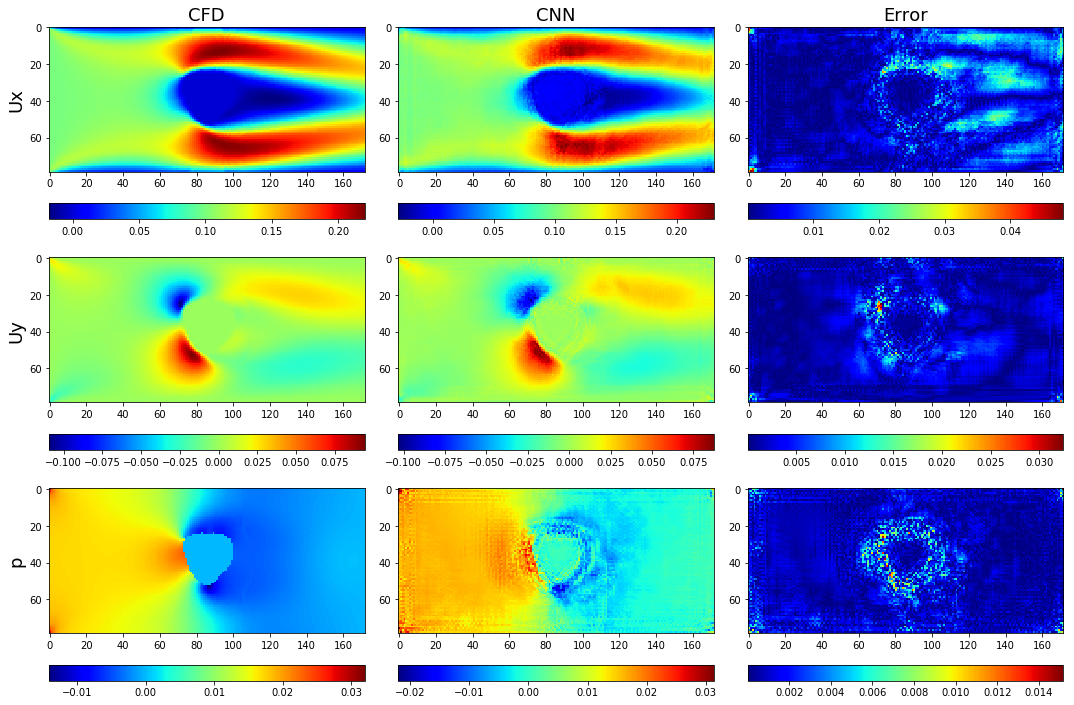

Epoch #131
	Train Loss = 92750.35711669922
	Train Total MSE = 3.2038124941644215
	Train Ux MSE = 1.4402064283688862
	Train Uy MSE = 0.3346743207602274
	Train p MSE = 1.428931743970939
	Validation Loss = 13122.362767219543
	Validation Total MSE = 1.658690273555505
	Validation Ux MSE = 1.1250616432679978
	Validation Uy MSE = 0.24138046788199963
	Validation p MSE = 0.29224819634560895
Epoch #132
	Train Loss = 89741.59118652344
	Train Total MSE = 3.0967665030842735
	Train Ux MSE = 1.3924461603164673
	Train Uy MSE = 0.3139438359510331
	Train p MSE = 1.390376410314015
	Validation Loss = 12907.051147460938
	Validation Total MSE = 1.6734878959127777
	Validation Ux MSE = 1.1555444163022157
	Validation Uy MSE = 0.2318657181100037
	Validation p MSE = 0.2860777771751361
Model saved!
Epoch #133
	Train Loss = 89610.4956665039
	Train Total MSE = 3.0808299155462358
	Train Ux MSE = 1.3774426891690208
	Train Uy MSE = 0.31370007282211665
	Train p MSE = 1.3896871102707726
	Validation Loss = 13354.87643241

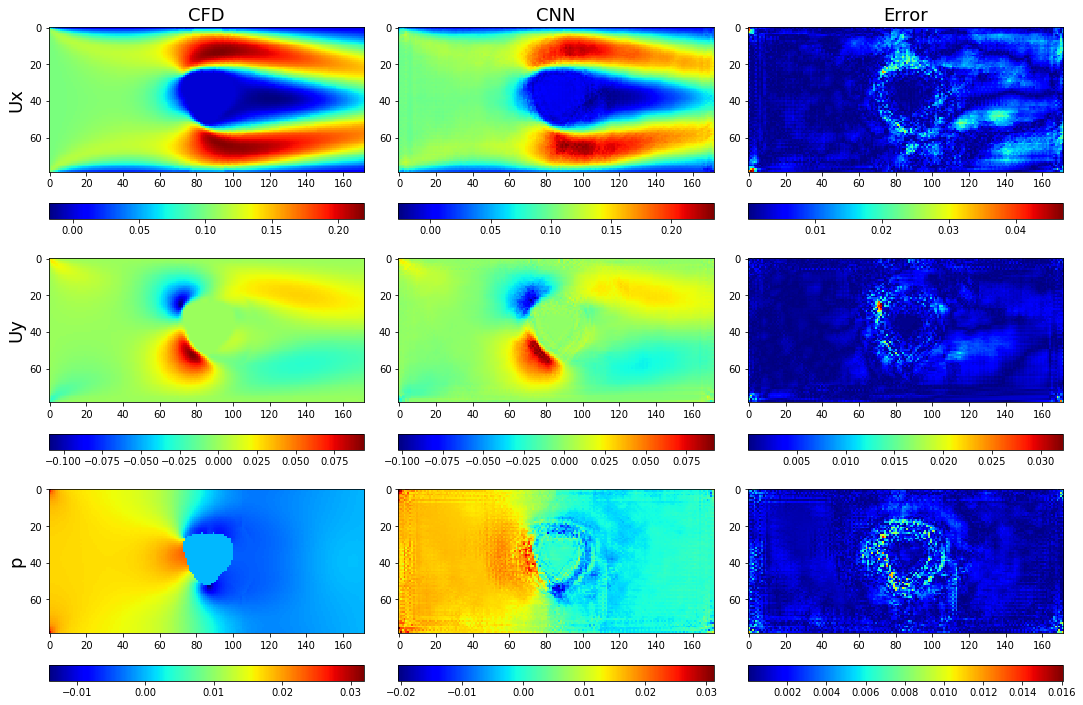

Epoch #141
	Train Loss = 90582.70190429688
	Train Total MSE = 3.0724142761457536
	Train Ux MSE = 1.3453022638956706
	Train Uy MSE = 0.3160553028186162
	Train p MSE = 1.41105674632958
	Validation Loss = 12781.54435634613
	Validation Total MSE = 1.59970203072967
	Validation Ux MSE = 1.0771383119289437
	Validation Uy MSE = 0.23789259701142262
	Validation p MSE = 0.28467104287502265
Epoch #142
	Train Loss = 89635.65942382812
	Train Total MSE = 3.0435621993882314
	Train Ux MSE = 1.3355385235377721
	Train Uy MSE = 0.310363878096853
	Train p MSE = 1.3976597807237081
	Validation Loss = 12711.760572433472
	Validation Total MSE = 1.6423537675484654
	Validation Ux MSE = 1.1338981008447164
	Validation Uy MSE = 0.2187591392069952
	Validation p MSE = 0.28969649707569795
Epoch #143
	Train Loss = 88824.06671142578
	Train Total MSE = 3.008288176286788
	Train Ux MSE = 1.3145709832509358
	Train Uy MSE = 0.30812041603383566
	Train p MSE = 1.385596726089716
	Validation Loss = 12568.238910675049
	Validation

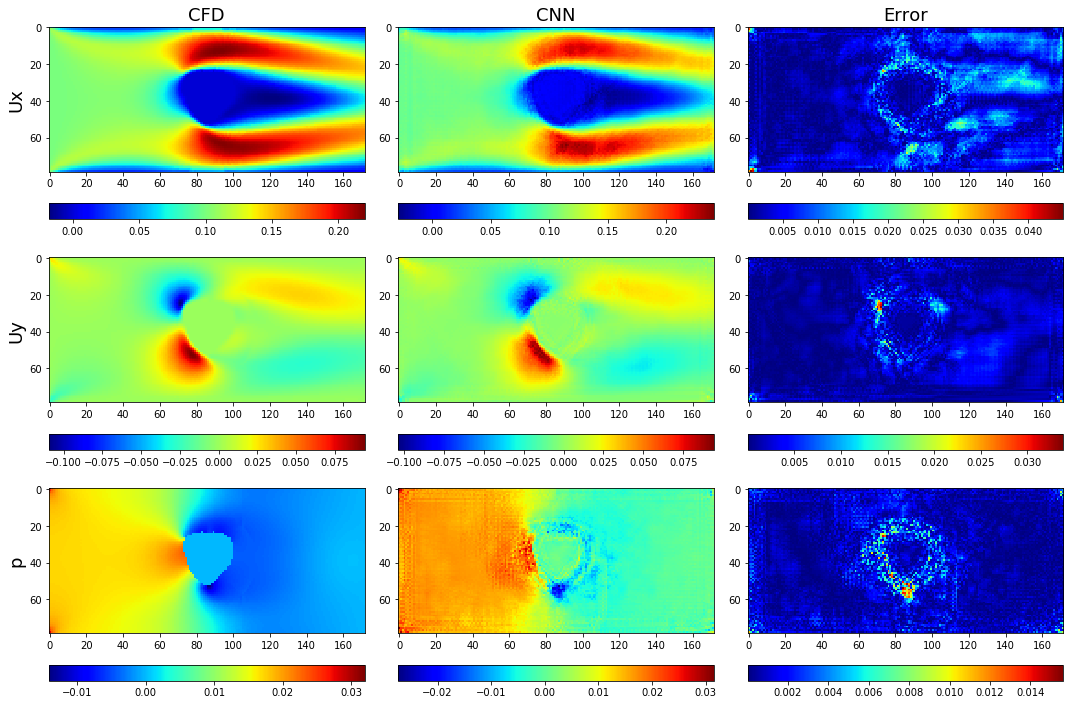

Epoch #151
	Train Loss = 87515.98126220703
	Train Total MSE = 2.9376477003097534
	Train Ux MSE = 1.2678174887384688
	Train Uy MSE = 0.29400370873156045
	Train p MSE = 1.375826548252787
	Validation Loss = 12111.928434371948
	Validation Total MSE = 1.504354820841324
	Validation Ux MSE = 1.01129831347911
	Validation Uy MSE = 0.21093280966616007
	Validation p MSE = 0.2821237266476179
Model saved!
Epoch #152
	Train Loss = 87818.32440185547
	Train Total MSE = 2.970470144635155
	Train Ux MSE = 1.298137707369668
	Train Uy MSE = 0.293900965934708
	Train p MSE = 1.378431504680997
	Validation Loss = 12384.774544715881
	Validation Total MSE = 1.5412912717327527
	Validation Ux MSE = 1.038630119450777
	Validation Uy MSE = 0.21131031498777
	Validation p MSE = 0.29135087854309477
Epoch #153
	Train Loss = 88503.36706542969
	Train Total MSE = 2.939735165664128
	Train Ux MSE = 1.2471422666595096
	Train Uy MSE = 0.29666321476300556
	Train p MSE = 1.3959296716465837
	Validation Loss = 13200.07486152649
	Va

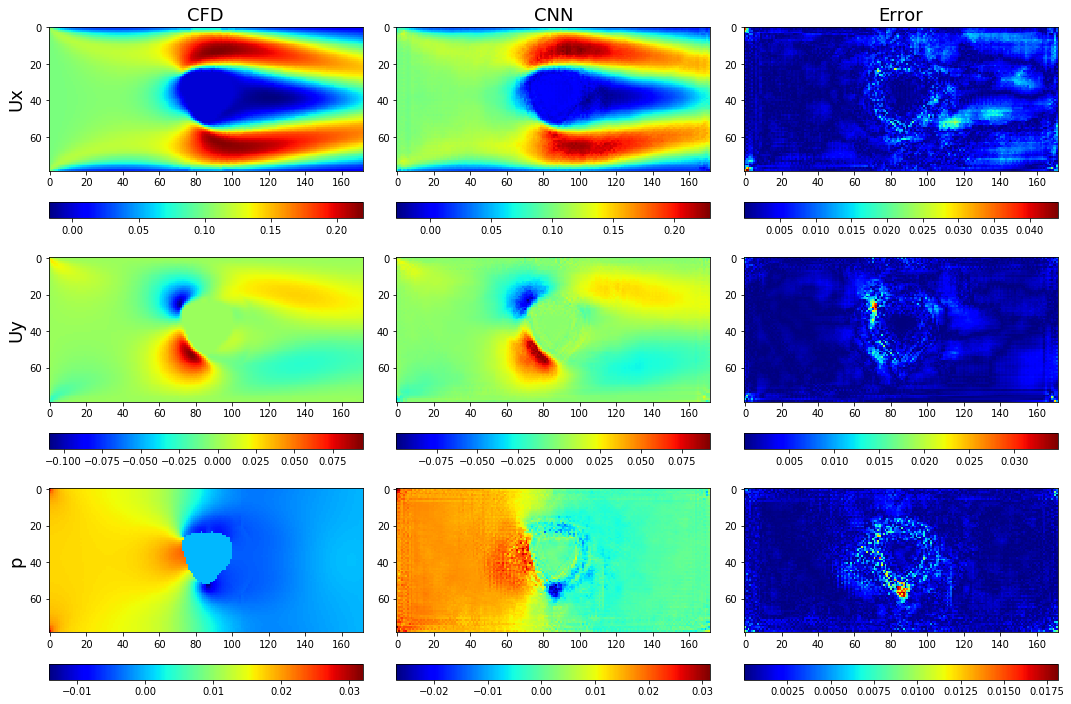

Epoch #161
	Train Loss = 87123.06048583984
	Train Total MSE = 2.8883019259997775
	Train Ux MSE = 1.2216692765553792
	Train Uy MSE = 0.29085393462862286
	Train p MSE = 1.375778660532974
	Validation Loss = 11818.221219062805
	Validation Total MSE = 1.4300095389458547
	Validation Ux MSE = 0.9437312046549312
	Validation Uy MSE = 0.2065848300819991
	Validation p MSE = 0.27969355118109696
Model saved!
Epoch #162
	Train Loss = 86979.31762695312
	Train Total MSE = 2.8920314453897022
	Train Ux MSE = 1.2297690766198295
	Train Uy MSE = 0.28837949073030833
	Train p MSE = 1.3738829397729464
	Validation Loss = 11826.011528015137
	Validation Total MSE = 1.4431146496719967
	Validation Ux MSE = 0.9600805299917307
	Validation Uy MSE = 0.19892116932514217
	Validation p MSE = 0.28411292238322094
Epoch #163
	Train Loss = 86962.15905761719
	Train Total MSE = 2.8904736638069153
	Train Ux MSE = 1.2284009059270222
	Train Uy MSE = 0.28835560168538776
	Train p MSE = 1.373717154775347
	Validation Loss = 11720.093

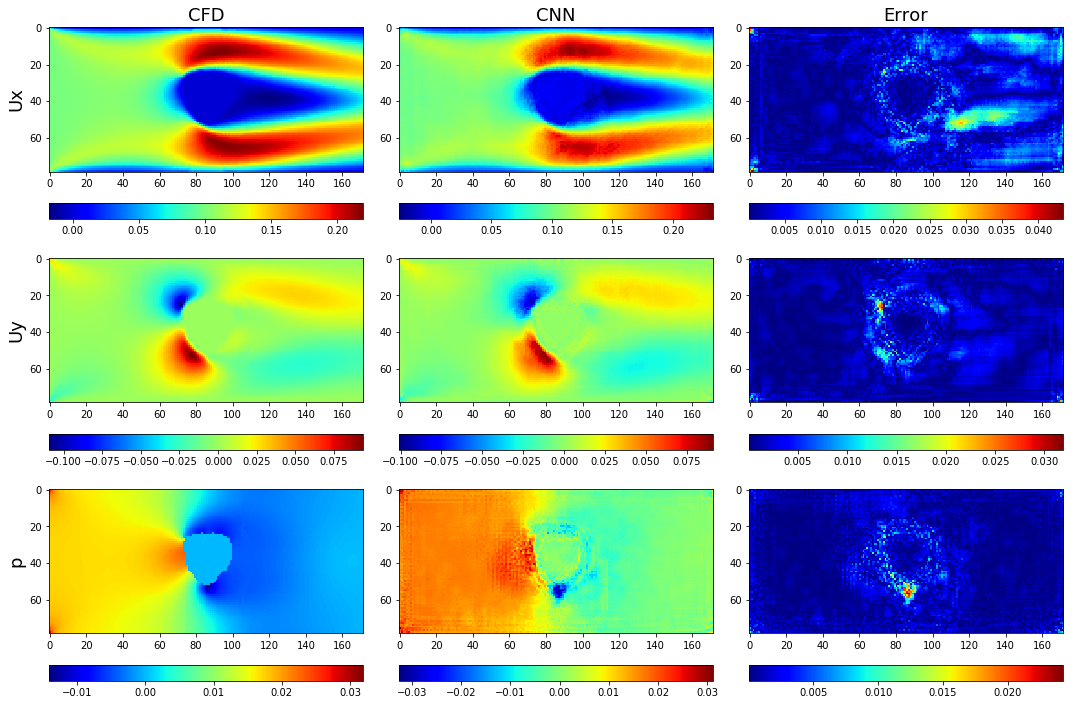

Epoch #171
	Train Loss = 86405.60998535156
	Train Total MSE = 2.8301771794046675
	Train Ux MSE = 1.1729492800576347
	Train Uy MSE = 0.2876602751868112
	Train p MSE = 1.3695676351586978
	Validation Loss = 11810.848533630371
	Validation Total MSE = 1.4425327728363881
	Validation Ux MSE = 0.9610715432150554
	Validation Uy MSE = 0.19554190549058484
	Validation p MSE = 0.2859193234604535
Epoch #172
	Train Loss = 85770.68795776367
	Train Total MSE = 2.818298924536932
	Train Ux MSE = 1.1762942941415877
	Train Uy MSE = 0.2781120091676712
	Train p MSE = 1.363892598343747
	Validation Loss = 11378.99701499939
	Validation Total MSE = 1.3693647207273332
	Validation Ux MSE = 0.9023303494733923
	Validation Uy MSE = 0.19033259462732757
	Validation p MSE = 0.2767018154005691
Model saved!
Epoch #173
	Train Loss = 85154.62823486328
	Train Total MSE = 2.7757470040094283
	Train Ux MSE = 1.142707048427491
	Train Uy MSE = 0.2756864864911352
	Train p MSE = 1.3573534509965353
	Validation Loss = 11599.182906150

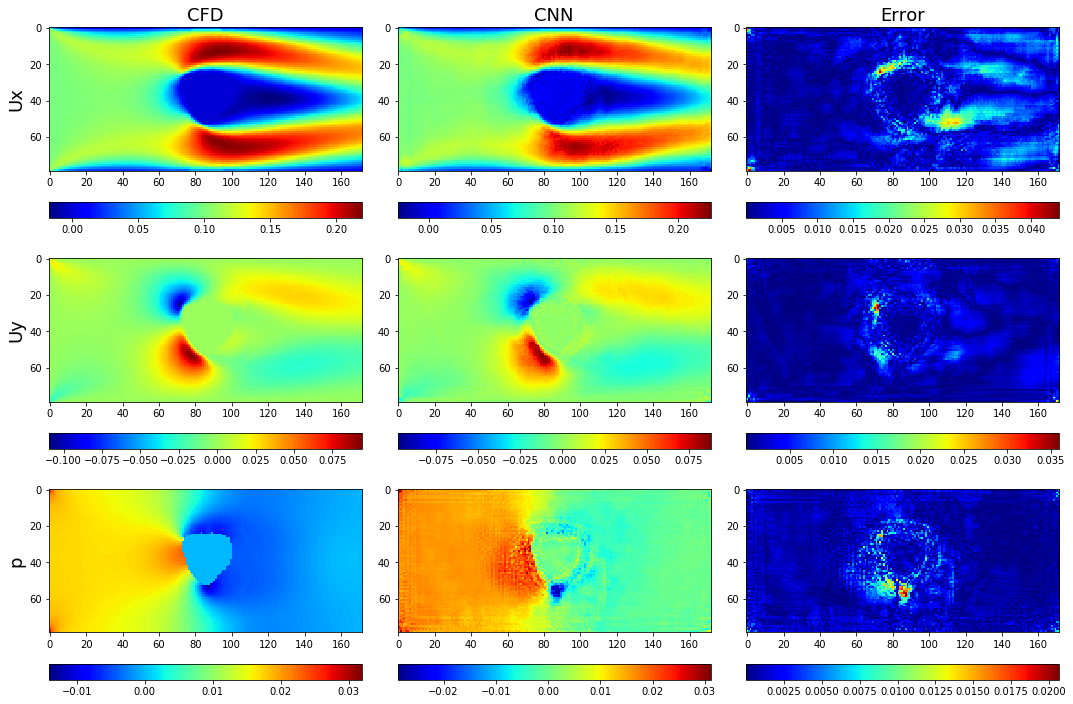

Epoch #181
	Train Loss = 85606.97454833984
	Train Total MSE = 2.791510337875003
	Train Ux MSE = 1.1501973952565874
	Train Uy MSE = 0.2760875090247109
	Train p MSE = 1.3652254864573479
	Validation Loss = 12467.6249294281
	Validation Total MSE = 1.3879435347025781
	Validation Ux MSE = 0.8657849140233235
	Validation Uy MSE = 0.19122986057225397
	Validation p MSE = 0.33092871952840613
Epoch #182
	Train Loss = 85933.00128173828
	Train Total MSE = 2.7815968422662642
	Train Ux MSE = 1.1327511611438932
	Train Uy MSE = 0.27148725447200595
	Train p MSE = 1.3773584708216644
	Validation Loss = 11592.109153747559
	Validation Total MSE = 1.36717968044809
	Validation Ux MSE = 0.8868659615104174
	Validation Uy MSE = 0.19734680956828965
	Validation p MSE = 0.2829669299680469
Epoch #183
	Train Loss = 85355.74203491211
	Train Total MSE = 2.7842316996483576
	Train Ux MSE = 1.1464251648812067
	Train Uy MSE = 0.28095977363132296
	Train p MSE = 1.3568467368327437
	Validation Loss = 11498.64171218872
	Validat

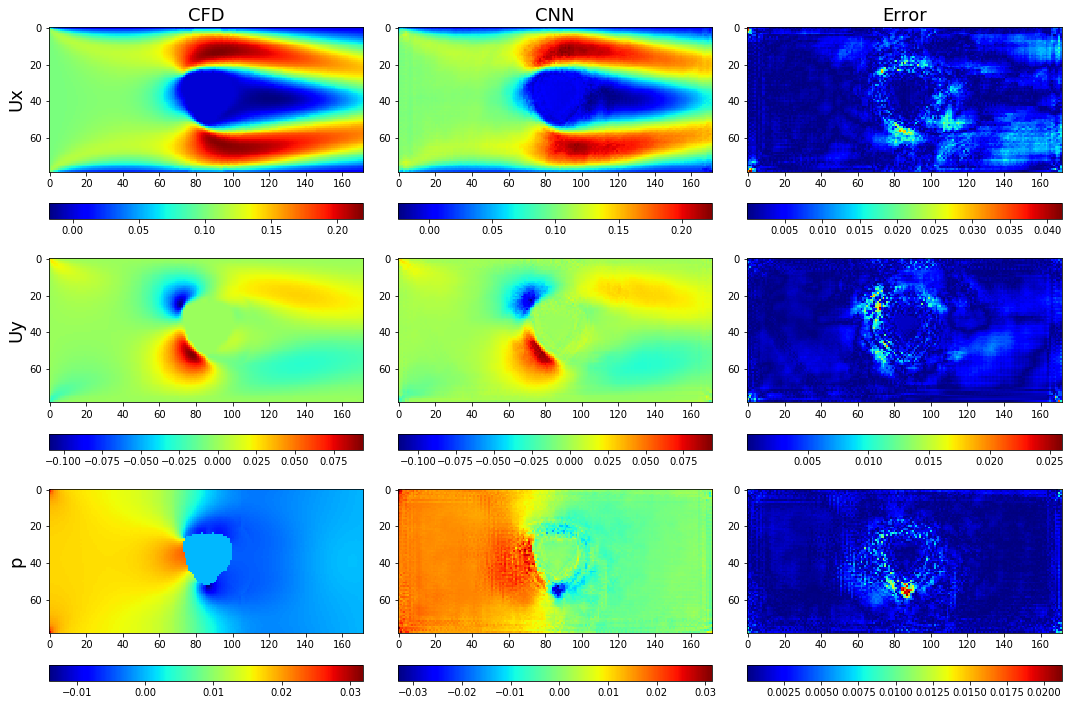

Epoch #191
	Train Loss = 85262.67938232422
	Train Total MSE = 2.741042449360802
	Train Ux MSE = 1.103152219738279
	Train Uy MSE = 0.26708126564820606
	Train p MSE = 1.3708089245926767
	Validation Loss = 11318.417202949524
	Validation Total MSE = 1.3113812240143548
	Validation Ux MSE = 0.8423564673295071
	Validation Uy MSE = 0.1805921271443367
	Validation p MSE = 0.2884326122417582
Epoch #192
	Train Loss = 84586.67114257812
	Train Total MSE = 2.6978800977979387
	Train Ux MSE = 1.0707621574401855
	Train Uy MSE = 0.2625501947033973
	Train p MSE = 1.364567680727868
	Validation Loss = 10995.139028549194
	Validation Total MSE = 1.2602612519552963
	Validation Ux MSE = 0.8015879807175237
	Validation Uy MSE = 0.18038320489820725
	Validation p MSE = 0.2782900490665931
Model saved!
Epoch #193
	Train Loss = 84072.15606689453
	Train Total MSE = 2.7012068061601546
	Train Ux MSE = 1.085506504490262
	Train Uy MSE = 0.2652357674780346
	Train p MSE = 1.3504645333048844
	Validation Loss = 11803.955215454

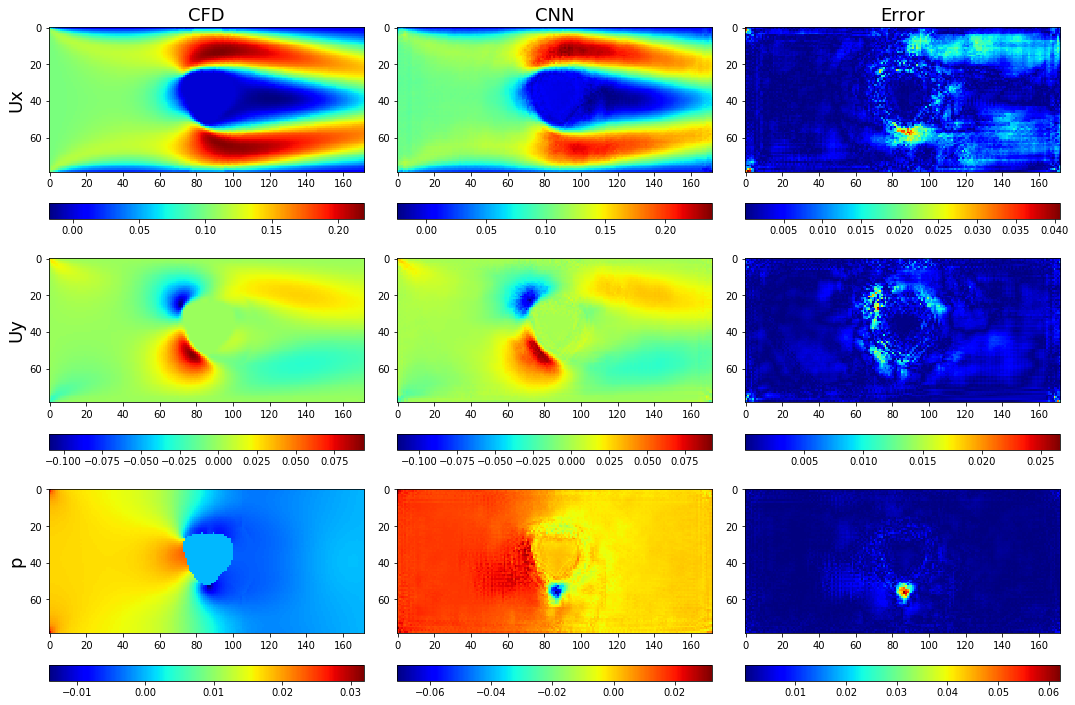

Epoch #201
	Train Loss = 83614.66110229492
	Train Total MSE = 2.6536255280176797
	Train Ux MSE = 1.0422311567124867
	Train Uy MSE = 0.2644176465414819
	Train p MSE = 1.3469768450373696
	Validation Loss = 11605.714925765991
	Validation Total MSE = 1.27314352721079
	Validation Ux MSE = 0.7852206236350907
	Validation Uy MSE = 0.175549439673399
	Validation p MSE = 0.3123734482921737
Epoch #202
	Train Loss = 83265.98629760742
	Train Total MSE = 2.661709984143575
	Train Ux MSE = 1.0600103991372245
	Train Uy MSE = 0.26151068898893537
	Train p MSE = 1.3401889020488376
	Validation Loss = 10761.909440040588
	Validation Total MSE = 1.249085776121146
	Validation Ux MSE = 0.8026082103227662
	Validation Uy MSE = 0.17489582104253934
	Validation p MSE = 0.2715817099649807
Model saved!
Epoch #203
	Train Loss = 82746.33853149414
	Train Total MSE = 2.6266996633438837
	Train Ux MSE = 1.0329550064745403
	Train Uy MSE = 0.2583638983113425
	Train p MSE = 1.335380737802812
	Validation Loss = 11538.90921211242

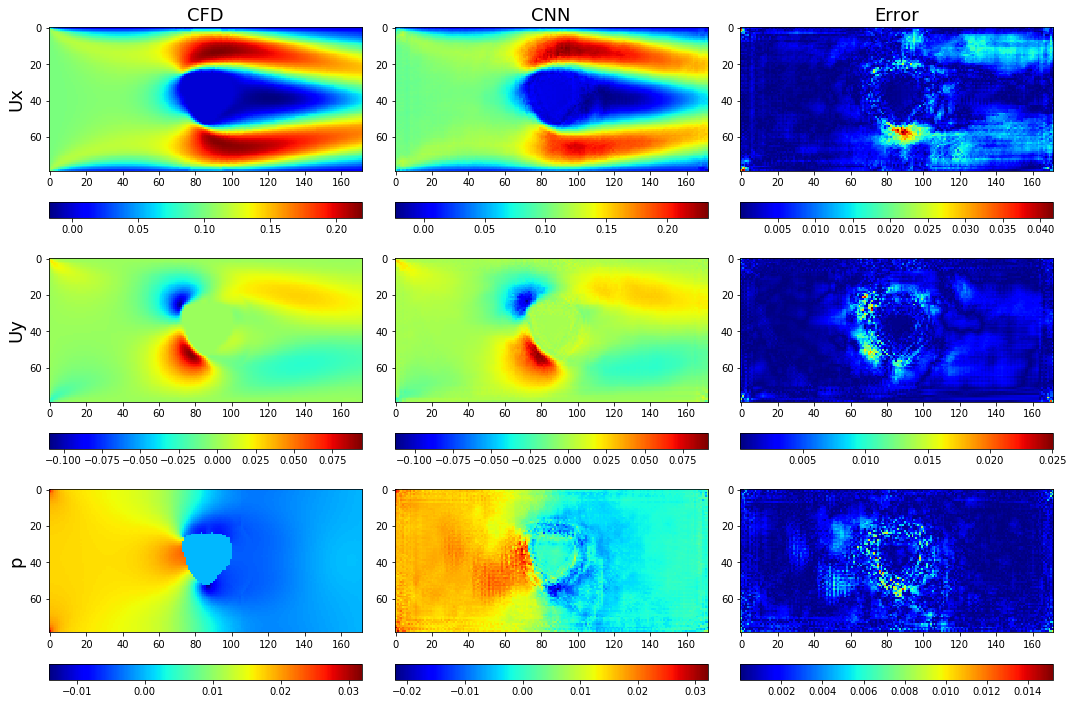

Epoch #211
	Train Loss = 81102.18359375
	Train Total MSE = 2.6118231302215937
	Train Ux MSE = 1.053306031794775
	Train Uy MSE = 0.2586028504939306
	Train p MSE = 1.2999142482876778
	Validation Loss = 11481.47172164917
	Validation Total MSE = 1.351823683016028
	Validation Ux MSE = 0.8810234964925112
	Validation Uy MSE = 0.17467664285308349
	Validation p MSE = 0.2961235709462611
Epoch #212
	Train Loss = 80200.99835205078
	Train Total MSE = 2.5801562184379216
	Train Ux MSE = 1.039736658334732
	Train Uy MSE = 0.2512486647991907
	Train p MSE = 1.289170849181357
	Validation Loss = 10738.36588191986
	Validation Total MSE = 1.2309087440629318
	Validation Ux MSE = 0.7849050844829387
	Validation Uy MSE = 0.16843420138202325
	Validation p MSE = 0.27756944162107255
Epoch #213
	Train Loss = 80219.43084716797
	Train Total MSE = 2.569705457914443
	Train Ux MSE = 1.0273987012250083
	Train Uy MSE = 0.2516211618979772
	Train p MSE = 1.29068559301751
	Validation Loss = 11321.660778999329
	Validation Tota

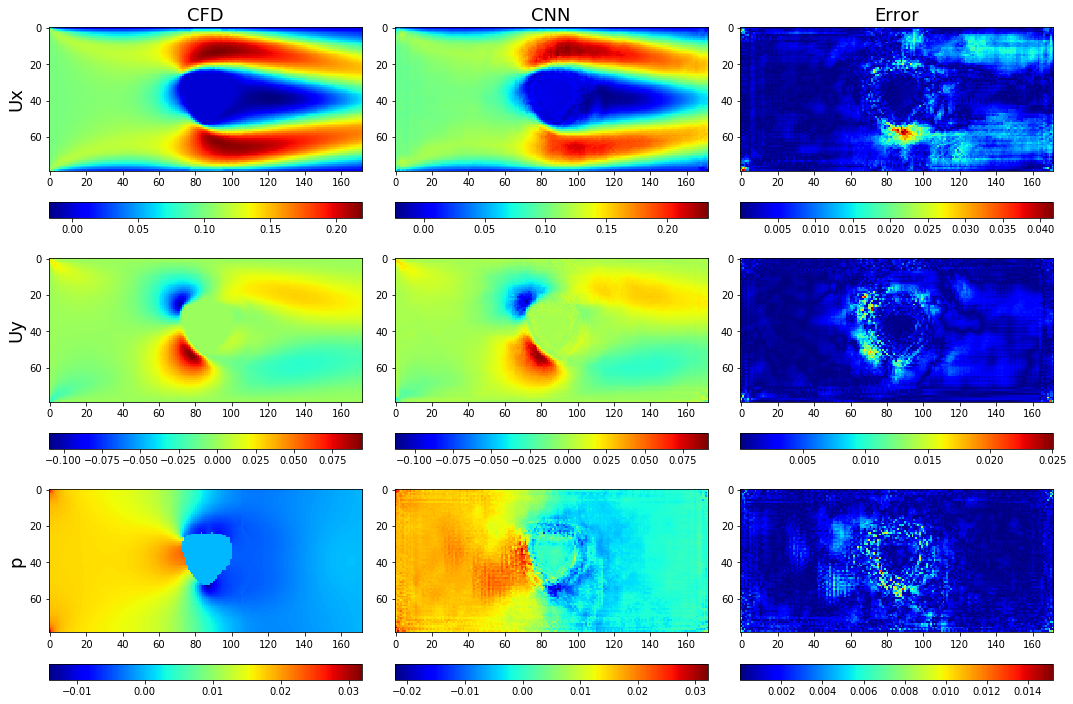

Epoch #221
	Train Loss = 81519.1003112793
	Train Total MSE = 2.5647490365164622
	Train Ux MSE = 0.9916749483063108
	Train Uy MSE = 0.25429271374429974
	Train p MSE = 1.3187814493264471
	Validation Loss = 10877.235503196716
	Validation Total MSE = 1.1882856477915622
	Validation Ux MSE = 0.7278141088551716
	Validation Uy MSE = 0.17455699501049973
	Validation p MSE = 0.28591457612580495
Epoch #222
	Train Loss = 79456.6968383789
	Train Total MSE = 2.526558776696523
	Train Ux MSE = 0.9958265480541048
	Train Uy MSE = 0.2517165516813596
	Train p MSE = 1.2790157135043825
	Validation Loss = 10917.260286331177
	Validation Total MSE = 1.1709421031615312
	Validation Ux MSE = 0.7102128332255209
	Validation Uy MSE = 0.15813637207742381
	Validation p MSE = 0.3025928664063087
Epoch #223
	Train Loss = 80282.28735351562
	Train Total MSE = 2.542822710105351
	Train Ux MSE = 0.9949862105505807
	Train Uy MSE = 0.25387235695407506
	Train p MSE = 1.2939641741769654
	Validation Loss = 10754.122667312622
	Valid

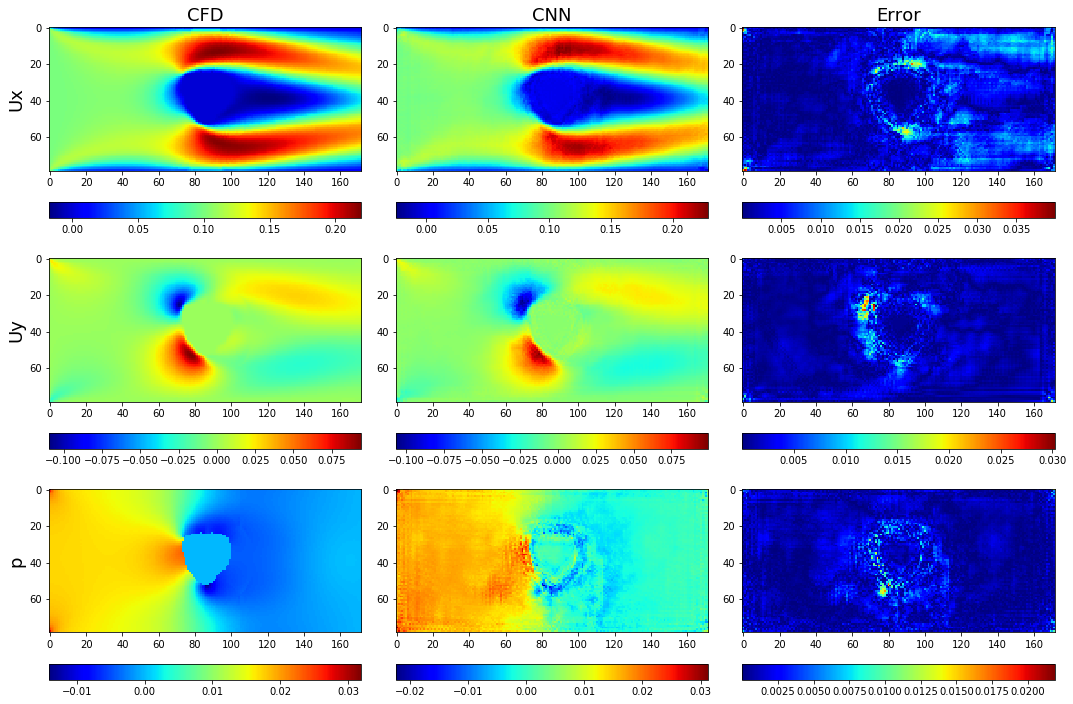

Epoch #231
	Train Loss = 79512.38806152344
	Train Total MSE = 2.5020955091431025
	Train Ux MSE = 0.9671658064637866
	Train Uy MSE = 0.2505843004300481
	Train p MSE = 1.284345248625392
	Validation Loss = 11080.386912345886
	Validation Total MSE = 1.2577263661321885
	Validation Ux MSE = 0.7938874887760122
	Validation Uy MSE = 0.1817395210678602
	Validation p MSE = 0.2820994050393468
Epoch #232
	Train Loss = 78601.99475097656
	Train Total MSE = 2.476859143802098
	Train Ux MSE = 0.9583928343795595
	Train Uy MSE = 0.25391311659699395
	Train p MSE = 1.2645530988063132
	Validation Loss = 10414.493465423584
	Validation Total MSE = 1.1388751002331505
	Validation Ux MSE = 0.698088741013748
	Validation Uy MSE = 0.16734782964713021
	Validation p MSE = 0.2734385469741475
Model saved!
Epoch #233
	Train Loss = 78313.13946533203
	Train Total MSE = 2.478082592998232
	Train Ux MSE = 0.967920238063449
	Train Uy MSE = 0.2475612060654731
	Train p MSE = 1.2626011332585698
	Validation Loss = 10553.1145858764

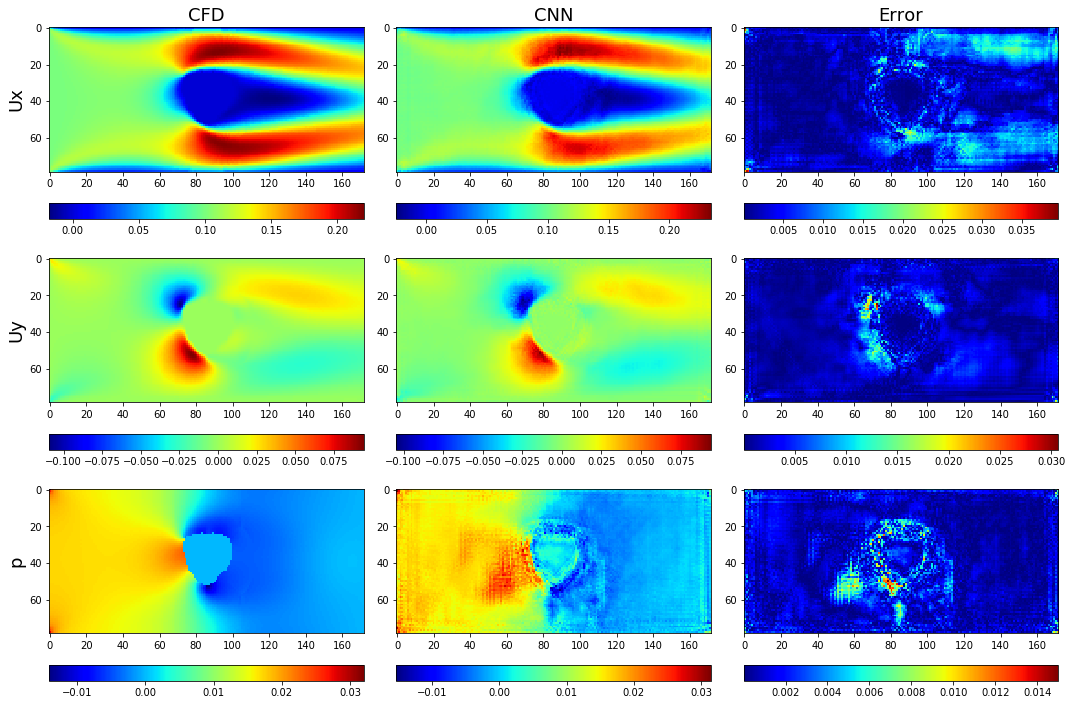

Epoch #241
	Train Loss = 77495.11169433594
	Train Total MSE = 2.43573689744586
	Train Ux MSE = 0.9393120479016077
	Train Uy MSE = 0.2444586544519379
	Train p MSE = 1.2519661645804132
	Validation Loss = 11928.897493362427
	Validation Total MSE = 1.3487539365629837
	Validation Ux MSE = 0.8501742385250475
	Validation Uy MSE = 0.18979809817352097
	Validation p MSE = 0.30878157336200396
Epoch #242
	Train Loss = 77306.88830566406
	Train Total MSE = 2.4417343650545393
	Train Ux MSE = 0.9498385233538491
	Train Uy MSE = 0.24654211494184675
	Train p MSE = 1.2453537226787634
	Validation Loss = 11835.367794036865
	Validation Total MSE = 1.2414509623108438
	Validation Ux MSE = 0.7374532629049361
	Validation Uy MSE = 0.17477612212867472
	Validation p MSE = 0.32922157719989137
Epoch #243
	Train Loss = 77002.47705078125
	Train Total MSE = 2.4338417166755315
	Train Ux MSE = 0.9476287904239836
	Train Uy MSE = 0.2472329671893801
	Train p MSE = 1.238979860430672
	Validation Loss = 12687.434073448181
	Vali

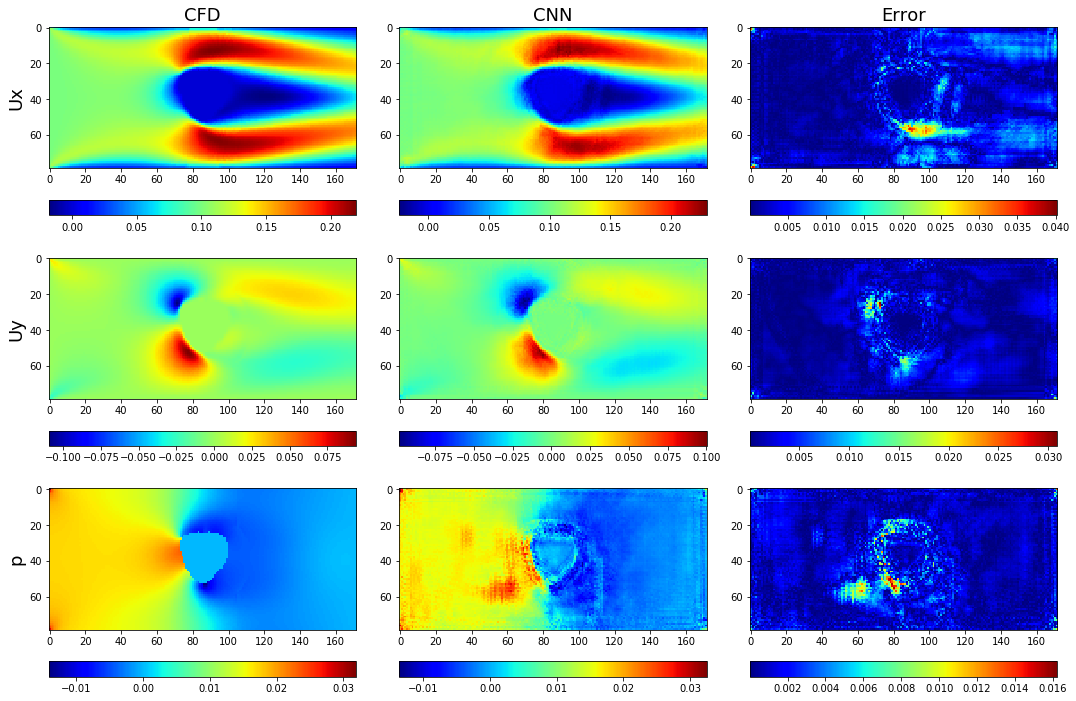

Epoch #251
	Train Loss = 76870.80770874023
	Train Total MSE = 2.4221505976858593
	Train Ux MSE = 0.9366315674214136
	Train Uy MSE = 0.2502116252269064
	Train p MSE = 1.235307352173896
	Validation Loss = 10341.921219825745
	Validation Total MSE = 1.1652316488196692
	Validation Ux MSE = 0.7321841430086578
	Validation Uy MSE = 0.1655755575656066
	Validation p MSE = 0.2674719334602562
Model saved!
Epoch #252
	Train Loss = 75646.17758178711
	Train Total MSE = 2.373797423782803
	Train Ux MSE = 0.9121879764965602
	Train Uy MSE = 0.240150039039907
	Train p MSE = 1.2214593482869012
	Validation Loss = 11173.08881187439
	Validation Total MSE = 1.3023003162397233
	Validation Ux MSE = 0.8395649433960964
	Validation Uy MSE = 0.1812688972556055
	Validation p MSE = 0.2814664738220533
Epoch #253
	Train Loss = 76788.72946166992
	Train Total MSE = 2.458599113282703
	Train Ux MSE = 0.9801103075345358
	Train Uy MSE = 0.2487328467624528
	Train p MSE = 1.2297559696294011
	Validation Loss = 12979.813529968262

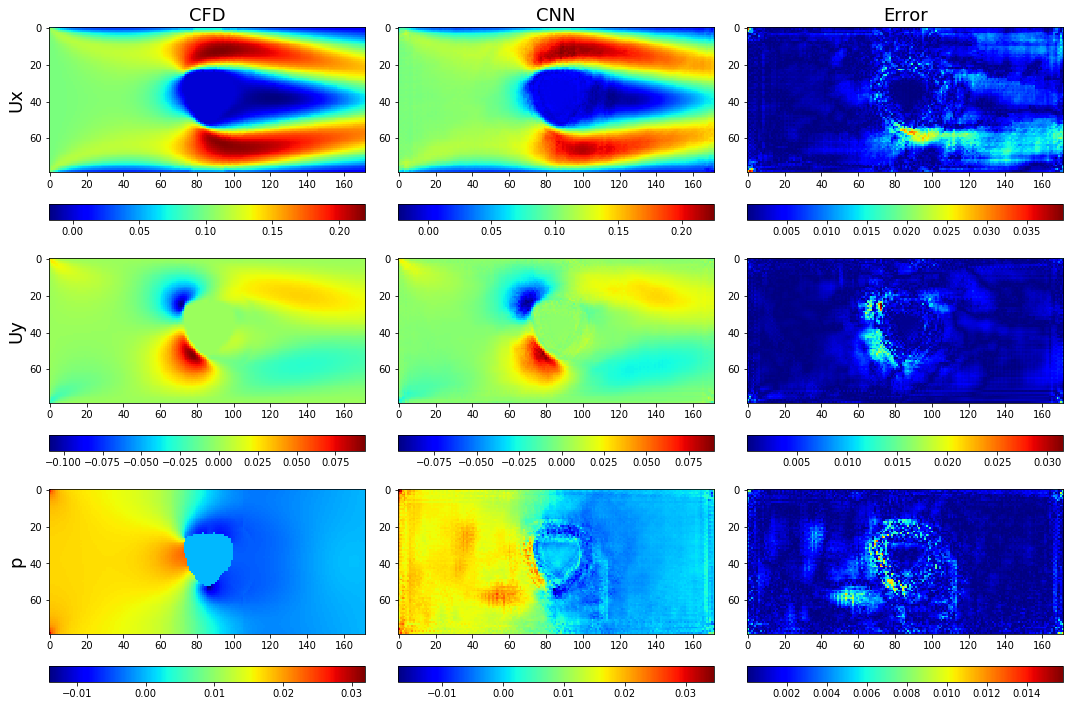

Epoch #261
	Train Loss = 74246.88018798828
	Train Total MSE = 2.3490749370484125
	Train Ux MSE = 0.9158103877589816
	Train Uy MSE = 0.24054646988709769
	Train p MSE = 1.192718162068299
	Validation Loss = 11183.636779785156
	Validation Total MSE = 1.212918178432953
	Validation Ux MSE = 0.7421924004711494
	Validation Uy MSE = 0.1640594411112858
	Validation p MSE = 0.3066663242567163
Epoch #262
	Train Loss = 74204.0122680664
	Train Total MSE = 2.3597652997289384
	Train Ux MSE = 0.9302009244759878
	Train Uy MSE = 0.23529631076824098
	Train p MSE = 1.1942680635977359
	Validation Loss = 10601.891832351685
	Validation Total MSE = 1.1618626305388744
	Validation Ux MSE = 0.7160331276873816
	Validation Uy MSE = 0.16019081084579745
	Validation p MSE = 0.2856387192170719
Epoch #263
	Train Loss = 72767.2710571289
	Train Total MSE = 2.3034293140683855
	Train Ux MSE = 0.8999398095267159
	Train Uy MSE = 0.2315458995955331
	Train p MSE = 1.1719435978503454
	Validation Loss = 12268.361623764038
	Validat

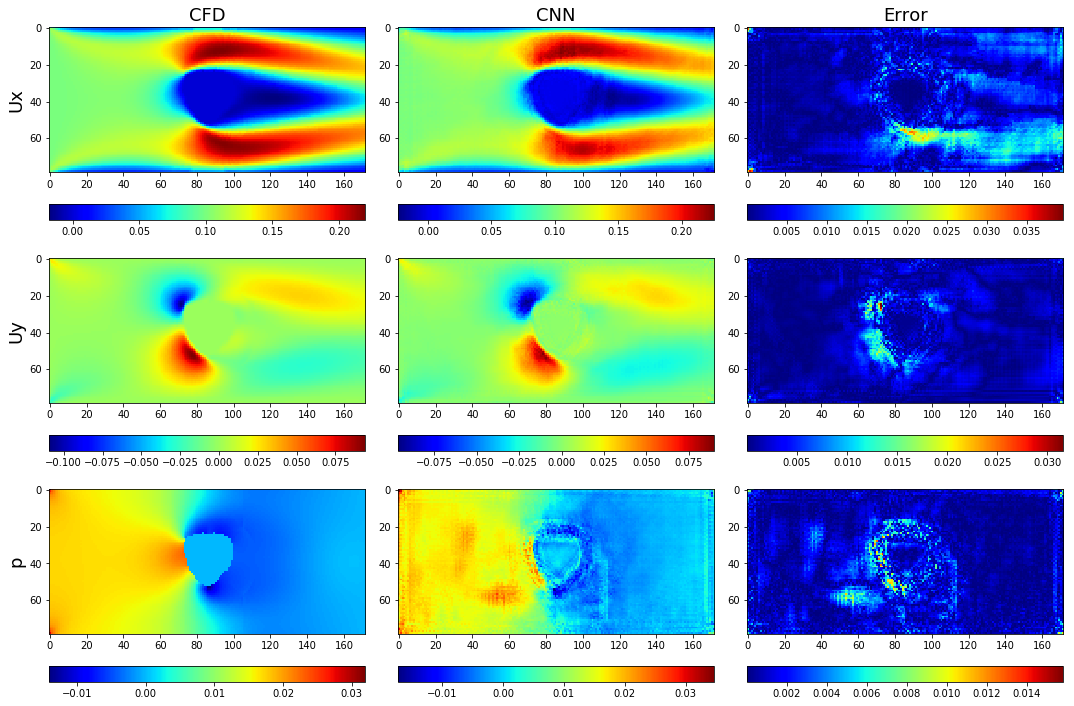

Epoch #271
	Train Loss = 78019.51098632812
	Train Total MSE = 2.407144467035929
	Train Ux MSE = 0.8970799417722792
	Train Uy MSE = 0.23649792053869792
	Train p MSE = 1.273566596210003
	Validation Loss = 10956.336158752441
	Validation Total MSE = 1.1794143985299503
	Validation Ux MSE = 0.7170465343138751
	Validation Uy MSE = 0.160899555265491
	Validation p MSE = 0.30146831413247593
Epoch #272
	Train Loss = 73182.7653503418
	Train Total MSE = 2.3161650938647136
	Train Ux MSE = 0.9057319873855227
	Train Uy MSE = 0.2283995563075656
	Train p MSE = 1.1820336205973512
	Validation Loss = 10543.151633262634
	Validation Total MSE = 1.120662007261725
	Validation Ux MSE = 0.6745157260383289
	Validation Uy MSE = 0.15219405806497718
	Validation p MSE = 0.2939522528447288
Epoch #273
	Train Loss = 75246.25494384766
	Train Total MSE = 2.391319263549078
	Train Ux MSE = 0.9417006373405457
	Train Uy MSE = 0.2376698198772612
	Train p MSE = 1.2119487204721995
	Validation Loss = 11535.578890800476
	Validatio

(UNetEx(
   (encoder): Sequential(
     (0): Sequential(
       (0): Sequential(
         (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
         (1): ReLU()
       )
       (1): Sequential(
         (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
         (1): ReLU()
       )
     )
     (1): Sequential(
       (0): Sequential(
         (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
         (1): ReLU()
       )
       (1): Sequential(
         (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
         (1): ReLU()
       )
     )
     (2): Sequential(
       (0): Sequential(
         (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
         (1): ReLU()
       )
       (1): Sequential(
         (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
         (1): ReLU()
       )
     )
     (3): Sequential(
       (0): Sequential(
         (0): Conv2d(32, 32, kern

In [18]:
# Training model
train_model(model, loss_func, train_dataset, test_dataset, optimizer,
           epochs=10000, batch_size=32, device=device, after_epoch=after_epoch,
           m_mse_name="Total MSE",
           m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
           m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_ux_name="Ux MSE",
           m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
           m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_uy_name="Uy MSE",
           m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
           m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_p_name="p MSE",
           m_p_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
           m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]), patience=25
           )